# Email Spam or Ham Detector
### AML 2304 Lab 3 - Group E

Build the following models that can predict whether a given email is Spam or Ham

1. Naive Bayes using Count Vectors with Unigram

2. Naive Bayes using TF-IDF with Unigram+Bigram

3. Naive Bayes using Word2Vec

4. Naive Bayes using GloVe

In [45]:
import os
import pandas as pd
import numpy as np
import email
import re
import nltk
import contractions
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from email import policy
from email.header import decode_header
from nltk.corpus import stopwords
from nltk.corpus import words
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import make_column_transformer
from sklearn.metrics import accuracy_score, precision_score, classification_report
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from pylab import rcParams


nltk.download('wordnet')
pd.set_option('max_colwidth', 100)

%matplotlib inline
rcParams['figure.figsize'] = 5,3

warnings.filterwarnings("ignore")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aurad\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Read file contents from Dataset main folder. Extract the `SUBJECT`, `TO`, `FROM` and `EMAIL BODY` from the email, then add the data in dataframe with the correct label: `spam` or `ham`

In [2]:
def get_email_body(msg):
    email_body = ""

    if "multipart" in msg.get_content_type():

        for part in msg.get_payload(decode=False):
            if not isinstance(part, str):
                email_part = str(part.get_payload(decode=False)).strip()
                email_body = email_body + email_part
    else:
        email_body = str(msg.get_payload(decode=False)).strip()

    return email_body


try:
    data_raw_df = pd.DataFrame(columns=['subject', 'to', 'from', 'email_body', 'label'])

    labels = ['ham', 'spam']
    for idx in range(len(labels)):

        spam_dir = "Dataset/" + labels[idx] + "/"
        # Read all files from the dataset folder
        for file in os.listdir(spam_dir)[:]:
            with open(spam_dir + file, "r", encoding="latin-1") as f:
                # Parse the email messages
                msg = email.message_from_string(f.read(), policy=policy.default)

                email_to = str(decode_header(msg.get('to'))[0][0]) if msg.get('to') is not None else ''
                email_from = str(decode_header(msg.get('from'))[0][0]) if msg.get('to') is not None else ''
                subject = str(decode_header(msg.get('subject'))[0][0]) if msg.get('subject') is not None else ''
                email_body = get_email_body(msg)

                # Add label to your record: 0 = ham, 1 = spam
                new_data = [subject, email_to, email_from, email_body, idx]
                data_raw_df.loc[len(data_raw_df)] = new_data

    display(data_raw_df.head(5))

except Exception as err:
    print(f"Error: {err} - filename: {file}")

,subject,to,from,email_body,label
0,Re: New Sequences Window,Chris Garrigues <cwg-dated-1030314468.7c7c85@DeepEddy.Com>,Robert Elz <kre@munnari.OZ.AU>,"Date: Tue, 20 Aug 2002 17:27:47 -0500\n From: Chris Garrigues <cwg-exmh@DeepEdd...",0
1,Re: New Sequences Window,Chris Garrigues <cwg-dated-1030377287.06fa6d@DeepEddy.Com>,Robert Elz <kre@munnari.OZ.AU>,"Date: Wed, 21 Aug 2002 10:54:46 -0500\n From: Chris Garrigues <cwg-dated-103037...",0
2,Personal Finance: Resolutions You Can Keep,mkettler@home.com,The Motley Fool <Fool@motleyfool.com>,======================== THE MOTLEY FOOL ========================\n PERSO...,0
3,Re: New Sequences Window,Valdis.Kletnieks@vt.edu,Chris Garrigues <cwg-exmh@DeepEddy.Com>,"> From: Valdis.Kletnieks@vt.edu\n> Date: Wed, 21 Aug 2002 02:36:56 -0400\n>\n> --==_Exmh_77858...",0
4,[zzzzteana] RE: Alexander,"""'zzzzteana@yahoogroups.com'"" <zzzzteana@yahoogroups.com>",Steve Burt <Steve_Burt@cursor-system.com>,"Martin A posted:\nTassos Papadopoulos, the Greek sculptor behind the plan, judged that the\n lim...",0


## Exploratory Data Analysis (incl. cleaning the data)

In [3]:
# Check if there are null values
print(data_raw_df.isnull().sum())

subject       0
to            0
from          0
email_body    0
label         0
dtype: int64


[Text(0, 0, '0: Ham (6701)'), Text(1, 0, '1: Spam (1896)')]

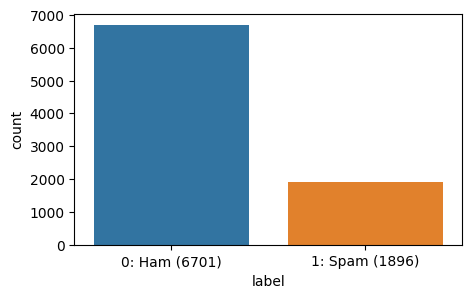

In [4]:
countplt = sns.countplot(x='label', data=data_raw_df)
countplt.set_xticklabels(['0: Ham (' + str(data_raw_df['label'].value_counts()[0]) + ")", '1: Spam (' + str(data_raw_df['label'].value_counts()[1]) + ')'])

Wordclout on `SUBJECT` and `EMAIL_BODY` for email raw data

Convert all characters to lower case before cleaning the data

In [5]:
# This variable will contain the cleaned data
data_cleaned_df = data_raw_df.copy()

data_cleaned_df = data_cleaned_df.applymap(lambda x: x.lower() if isinstance(x, str) else x)
data_cleaned_df.head(5)

,subject,to,from,email_body,label
0,re: new sequences window,chris garrigues <cwg-dated-1030314468.7c7c85@deepeddy.com>,robert elz <kre@munnari.oz.au>,"date: tue, 20 aug 2002 17:27:47 -0500\n from: chris garrigues <cwg-exmh@deepedd...",0
1,re: new sequences window,chris garrigues <cwg-dated-1030377287.06fa6d@deepeddy.com>,robert elz <kre@munnari.oz.au>,"date: wed, 21 aug 2002 10:54:46 -0500\n from: chris garrigues <cwg-dated-103037...",0
2,personal finance: resolutions you can keep,mkettler@home.com,the motley fool <fool@motleyfool.com>,======================== the motley fool ========================\n perso...,0
3,re: new sequences window,valdis.kletnieks@vt.edu,chris garrigues <cwg-exmh@deepeddy.com>,"> from: valdis.kletnieks@vt.edu\n> date: wed, 21 aug 2002 02:36:56 -0400\n>\n> --==_exmh_77858...",0
4,[zzzzteana] re: alexander,"""'zzzzteana@yahoogroups.com'"" <zzzzteana@yahoogroups.com>",steve burt <steve_burt@cursor-system.com>,"martin a posted:\ntassos papadopoulos, the greek sculptor behind the plan, judged that the\n lim...",0


Extract mail server and domain name from `TO` and `FROM`

Notes: Some values are marked as "undisclosed-recipient" for `TO`, resulting for blank text after extraction 

In [6]:
def extract_mail_server_and_domain(text):
    email_list = []
    email_tokens = text.split(",")

    for email in email_tokens:
        match = re.search(r'@([\w.]+\.[a-z]{2,})', email)
        if match:
            email_list.append(match.group(1))

    return email_list

data_cleaned_df[['to', 'from']] = data_cleaned_df[['to', 'from']].applymap(extract_mail_server_and_domain)
data_cleaned_df[['to', 'from']].head(5)

,to,from
0,[deepeddy.com],[munnari.oz.au]
1,[deepeddy.com],[munnari.oz.au]
2,[home.com],[motleyfool.com]
3,[vt.edu],[deepeddy.com]
4,[yahoogroups.com],[]


Get top 50 words with highest frequency for `TO` and `FROM`

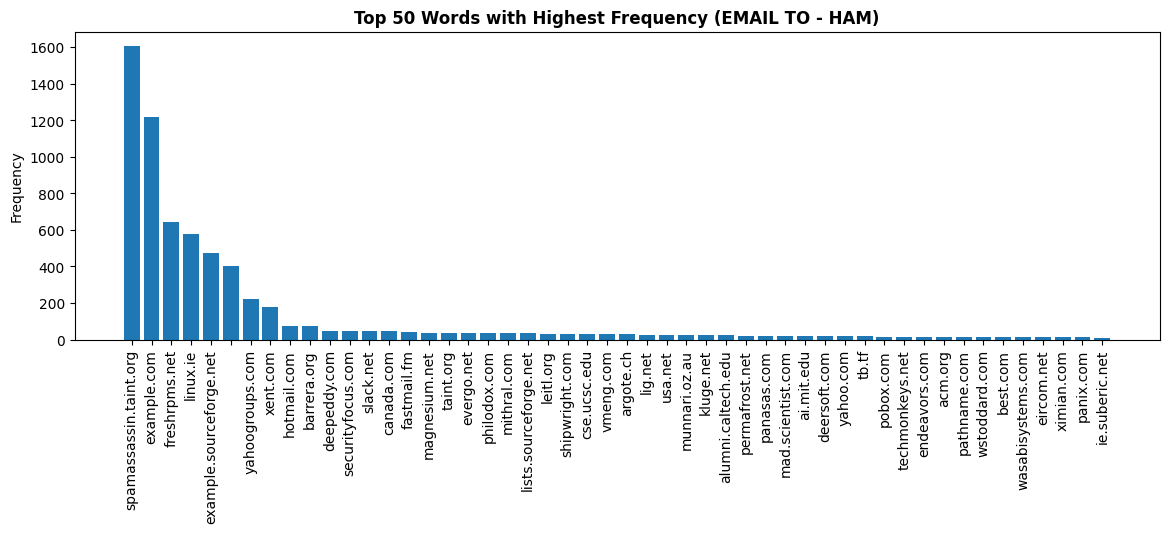

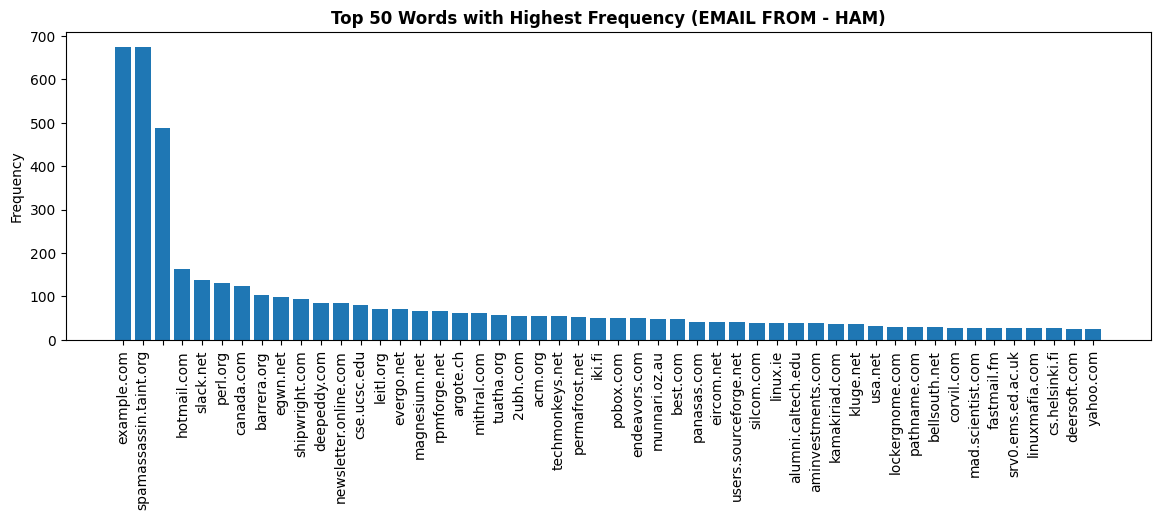

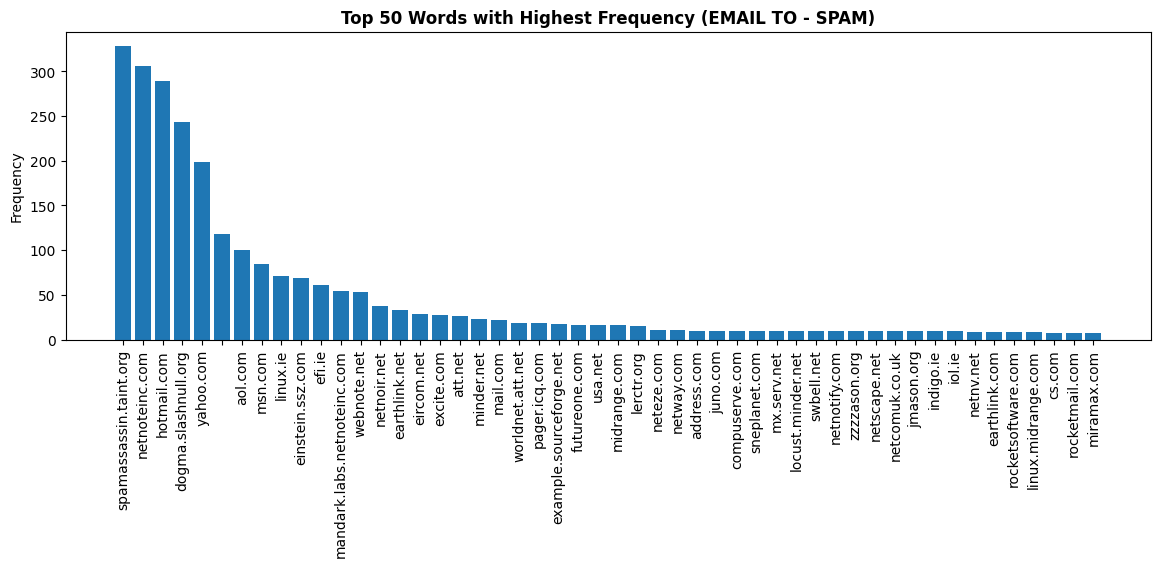

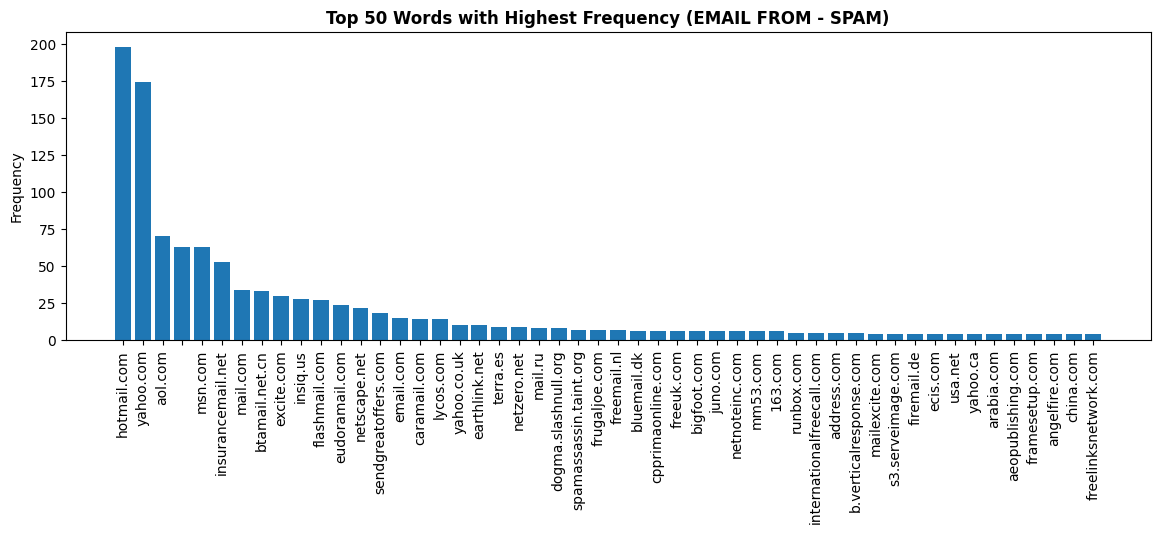

In [7]:
for idx, label in enumerate(labels):
    columns = ['to', 'from']

    for column in columns:
        email = data_cleaned_df[column][data_cleaned_df['label'] == idx]
        combined_emails = ','.join(email.apply(lambda x : ','.join(x)))
        email_list = combined_emails.split(",")
        email_counts = Counter(email_list)
        top_50_words = email_counts.most_common(50)

        # Separate the words and their counts for plotting
        top_words, counts = zip(*top_50_words)

        # Create a bar graph
        plt.figure(figsize=(14, 4))
        plt.bar(top_words, counts)
        plt.ylabel('Frequency')
        plt.title('Top 50 Words with Highest Frequency (EMAIL ' + column.upper() + ' - ' + label.upper() + ')', weight='bold')
        plt.xticks(rotation=90)
        plt.show()

For `SUBJECT` and `EMAIL_BODY`, the following will be applied to clean the data
- Remove email addresses and URLs
- Remove HTML tags and scripting variable names
- Replace all whitespaces with space
- Handling contractions
- Remove special characters and numbers
- Tokenization, stopwords removal and lemmatization
- Handling typos and mispellings (?)
- Remove words that are not in dictionary (?)

In [8]:
pd.set_option('max_colwidth', None)

stop_words = set(stopwords.words('english'))

def remove_unnecessary_words(text):

    # Remove HTML tags
    pattern_html = r'<[^>]+>'
    text = re.sub(pattern_html, '', text)
    text = text.replace('nbsp', ' ')

    # Remove scripting variable names, e.g. $msg
    pattern_scripting = r'\$\w+\s*'
    text = re.sub(pattern_scripting, '', text)

    # Remove email addresses
    pattern_email = r'\b[a-z0-9._%+-]+@[a-z0-9.-]+\.[a-z]{2,7}\b'    
    text = re.sub(pattern_email, '', text)

    # Remove URLs
    pattern_url = r'https?://(?:www\.)?[\w\.-]+(?:\.[a-z]{2,})+(?:/[-\w\.,/]*)*(?:\?[\w\%&=]*)?'
    text = re.sub(pattern_url, '', text)

    # Handle contractions
    text = contractions.fix(text)

    # Remove all special characters and numbers
    pattern_special_num = r'(?<![a-z])-(?![a-z])|[^a-z\s-]+'
    text = re.sub(pattern_special_num, ' ', text)

    # Replace all whitespaces (new lines, tabs, etc.) to space
    pattern_whitespace = r'\s+'
    text = re.sub(pattern_whitespace, ' ', text)

    # Tokenize the text and remove stopwords
    word_list = [word for word in word_tokenize(text) if word not in stop_words]    

    return word_list


data_cleaned_df[['subject', 'email_body']] = data_cleaned_df[['subject', 'email_body']].applymap(remove_unnecessary_words)

display(data_cleaned_df.head(5))

,subject,to,from,email_body,label
0,"[new, sequences, window]",[deepeddy.com],[munnari.oz.au],"[date, tue, aug, chris, garrigues, message-id, hoping, people, additional, sequences, notice, purely, cosmetic, changes, well, first, exmh, latest, one, changes, starts, get, read, flist, totalcount, unseen, element, array, executing, totalcount, unseen-sequence, flaginner, spool, iconspool, labelup, else, flaginner, icondown, labeldown, procedure, flag, msgseen, line, invoked, within, flag, msgseen, procedure, msgseen, line, invoked, within, msgseen, procedure, msgshow, line, invoked, within, msgshow, procedure, msgchange, line, invoked, within, msgchange, show, invoked, within, time, list, msgchange, procedure, msg, change, line, invoked, within, msg, change, id, procedure, msg, show, line, invoked, within, msg, show, cur, eval, body, line, invoked, within, eval, procedure, folderchange, line, invoked, within, ...]",0
1,"[new, sequences, window]",[deepeddy.com],[munnari.oz.au],"[date, wed, aug, chris, garrigues, message-id, reproduce, error, repeatable, like, every, time, without, fail, debug, log, pick, happening, pick, exec, pick, inbox, -list, -lbrace, -lbrace, -subject, ftp, -rbrace, -rbrace, -sequence, mercury, exec, pick, inbox, -list, -lbrace, -lbrace, -subject, ftp, -rbrace, -rbrace, -sequence, mercury, ftoc, pickmsgs, hit, marking, hits, tkerror, syntax, error, expression, int, note, run, pick, command, hand, delta, pick, inbox, -list, -lbrace, -lbrace, -subject, ftp, -rbrace, -rbrace, -sequence, mercury, hit, hit, comes, obviously, version, nmh, using, delta, pick, -version, pick, nmh-, compiled, fuchsia, cs, mu, oz, au, sun, mar, ict, relevant, part, mh, profile, delta, mhparam, pick, -seq, sel, ...]",0
2,"[personal, finance, resolutions, keep]",[home.com],[motleyfool.com],"[motley, fool, personal, finance, wednesday, january, issue, ask, fool, stop, solicitation, money, resolutions, keep, spotlight, savings, market, community, tips, least, one, thing, differently, sponsored, datek, datek, online, built, trade, proprietary, auto, routing, technology, commission, online, equity, trades, -second, execution, commitment, apply, datek, account, ask, fool, q, tired, getting, many, credit, card, offers, mail, already, card, want, mail, offering, new, ones, stop, three, main, credit, bureaus, united, states, agreed, someone, contacts, one, asks, removed, junk, mail, er, direct, mail, lists, telemarketing, phone, lists, honor, request, full, answer, money, resolutions, keep, let, us, face, new, year, resolutions, mostly, nightmares, hang, heads, like, ...]",0
3,"[new, sequences, window]",[vt.edu],[deepeddy.com],"[date, wed, aug, exmh, p, content-type, text, plain, charset, us-ascii, tue, aug, edt, said, ever, tried, get, mh, pseq, sequence, suspect, everybod, looking, big, box, unseen, pseq, might, want, add, pseq, hide, default, list, intended, added, sequence, never, show, list, take, effect, till, stopped, restarted, exmh, added, pseq, hit, save, preferences, take, effect, till, restarted, one, point, worked, fine, check, see, stopped, working, chris, chris, garrigues, cwg, vircio, congress, suite, austin, tx, world, war, iii, wrong-doers, vs, evil-doers, -begin, pgp, signature-, version, gnupg, v, gnu, linux, comment, exmh, version, id, dbqe, gk, b, h, r, iuirasiyaj, zejm, b, tiqdd, mqu, ...]",0
4,"[zzzzteana, alexander]",[yahoogroups.com],[],"[martin, posted, tassos, papadopoulos, greek, sculptor, behind, plan, judged, limestone, mount, kerdylio, miles, east, salonika, far, mount, athos, monastic, community, ideal, patriotic, sculpture, well, alexander, granite, features, ft, high, ft, wide, museum, restored, amphitheatre, car, park, admiring, crowds, planned, mountain, limestone, granite, limestone, weather, pretty, fast, yahoo, groups, sponsor, dvds, free, p, join, unsubscribe, group, send, email, use, yahoo, groups, subject]",0


In [9]:
# Handling typos and mispellings
english_vocab = set(w.lower() for w in words.words())


def lemmatize_word(word, pos=None):
    lemmatizer = WordNetLemmatizer()
    if pos is None:
        return lemmatizer.lemmatize(word)        
    
    return lemmatizer.lemmatize(word, pos=pos)


def suggest_words(word, threshold=3):
    suggested_words = [e_word for e_word in english_vocab if edit_distance(word, e_word) <= threshold]
    return suggested_words


def is_combined_word(word_list, index):
    combined_word = word_list[index] + word_list[index+1]
    lemmatized_word = lemmatize_word(combined_word, 'v')

    # Check if the combined word is in the dictionary and not a stopword
    if lemmatized_word in english_vocab and lemmatized_word not in stop_words:
        word_list[index] = lemmatize_word(combined_word)
        word_list.pop(index+1)
        return True

    return False


def handle_mispelling_words(word_list):
    word_list_size = len(word_list)-1
    idx = 0
    
    while idx < word_list_size:
        # Remove trailing and leading dash(es)
        cleaned_word = re.sub(r'^-+|-+$', '', word_list[idx])
        cleaned_word = cleaned_word.strip()

        is_lemmatized = False
        # Check if any of two consecutive words (current and after) aren't in dictionary and 
        # see if putting them together might work
        if any(word not in english_vocab for word in word_list[idx:idx+2]):
            # Check if two words can be combined
            is_valid_word = is_combined_word(word_list, idx)
            if is_valid_word:
                word_list_size = word_list_size - 1
            else:
                is_lemmatized = True
        else:
            is_lemmatized = True

        # Lemmatize the word
        if is_lemmatized:
            # Remove one-character word from the list
            if len(cleaned_word) == 1:
                word_list.pop(idx)    
                word_list_size = word_list_size - 1
            else:
                # suggested_words = suggest_words(cleaned_word)
                # TODO: Improve this section of the code
                # For now, we only take words that have error distance of 3
                # if len(suggested_words) == 0:
                #     word_list.pop(idx)    
                #     word_list_size = word_list_size - 1
                # else:
                word_list[idx] = lemmatize_word(cleaned_word)
            
        idx = idx + 1

    return word_list


data_cleaned_df[['subject', 'email_body']] = data_cleaned_df[['subject', 'email_body']].applymap(lambda x : handle_mispelling_words(x))
data_cleaned_df[['subject', 'email_body']].head(5)

,subject,email_body
0,"[new, sequence, window]","[date, tue, aug, chris, garrigues, message-id, hoping, people, additional, sequence, notice, purely, cosmetic, change, well, first, exmh, latest, one, change, start, get, read, flist, totalcount, unseen, element, array, executing, totalcount, unseen-sequence, flaginner, spool, iconspool, labelup, else, flaginner, icondown, labeldown, procedure, flag, msgseen, line, invoked, within, flag, msgseen, procedure, msgseen, line, invoked, within, msgseen, procedure, msgshow, line, invoked, within, msgshow, procedure, msgchange, line, invoked, within, msgchange, show, invoked, within, time, list, msgchange, procedure, msg, change, line, invoked, within, msg, change, id, procedure, msg, show, line, invoked, within, msg, show, cur, eval, body, line, invoked, within, eval, procedure, folderchange, line, invoked, within, ...]"
1,"[new, sequence, window]","[date, wed, aug, chris, garrigues, message-id, reproduce, error, repeatable, like, every, time, without, fail, debug, log, pick, happening, pick, exec, pick, inbox, list, lbrace, lbrace, subject, ftp, rbrace, rbrace, sequence, mercury, exec, pick, inbox, list, lbrace, lbrace, subject, ftp, rbrace, rbrace, sequence, mercury, ftoc, pickmsgs, hit, marking, hit, tkerror, syntax, error, expression, int, note, run, pick, command, hand, delta, pick, inbox, list, lbrace, lbrace, subject, ftp, rbrace, rbrace, sequence, mercury, hit, hit, come, obviously, version, nmh, using, delta, pick, version, pick, nmh, compiled, fuchsia, c, mu, oz, au, sun, mar, ict, relevant, part, mh, profile, delta, mhparam, pick, seq, sel, ...]"
2,"[personal, finance, resolution, keep]","[motley, fool, personal, finance, wednesday, january, issue, ask, fool, stop, solicitation, money, resolution, keep, spotlight, saving, market, community, tip, least, one, thing, differently, sponsored, datek, datek, online, built, trade, proprietary, auto, routing, technology, commission, online, equity, trade, second, execution, commitment, apply, datek, account, ask, fool, tired, getting, many, credit, card, offer, mail, already, card, want, mail, offering, new, one, stop, three, main, credit, bureau, united, state, agreed, someone, contact, one, asks, removed, junk, mail, er, direct, mail, list, telemarketing, phone, list, honor, request, full, answer, money, resolution, keep, let, u, face, new, year, resolution, mostly, nightmare, hang, head, like, dark, ...]"
3,"[new, sequence, window]","[date, wed, aug, exmh, content-type, text, plain, charset, us-ascii, tue, aug, edt, said, ever, tried, get, mh, pseq, sequence, suspect, everybod, looking, big, box, unseen, pseq, might, want, add, pseq, hide, default, list, intended, added, sequence, never, show, list, take, effect, till, stopped, restarted, exmh, added, pseq, hit, save, preference, take, effect, till, restarted, one, point, worked, fine, check, see, stopped, working, chris, chris, garrigues, cwg, vircio, congress, suite, austin, tx, world, war, iii, wrong-doers, v, evil-doers, begin, pgp, signature, version, gnupg, gnu, linux, comment, exmh, version, id, dbqe, gk, h, iuirasiyaj, zejm, tiqdd, mqu, lbapzzpasgcccjtl, bdfb, wkmtagwylf, xoou, wc, ...]"
4,"[zzzzteana, alexander]","[martin, posted, tasso, papadopoulos, greek, sculptor, behind, plan, judged, limestone, mount, kerdylio, mile, east, salonika, far, mount, athos, monastic, community, ideal, patriotic, sculpture, well, alexander, granite, feature, ft, high, ft, wide, museum, restored, amphitheatre, car, park, admiring, crowd, planned, mountain, limestone, granite, limestone, weather, pretty, fast, yahoo, group, sponsor, dvd, free, join, unsubscribe, group, send, email, use, yahoo, group, subject]"


Compare word clout of raw and cleaned data

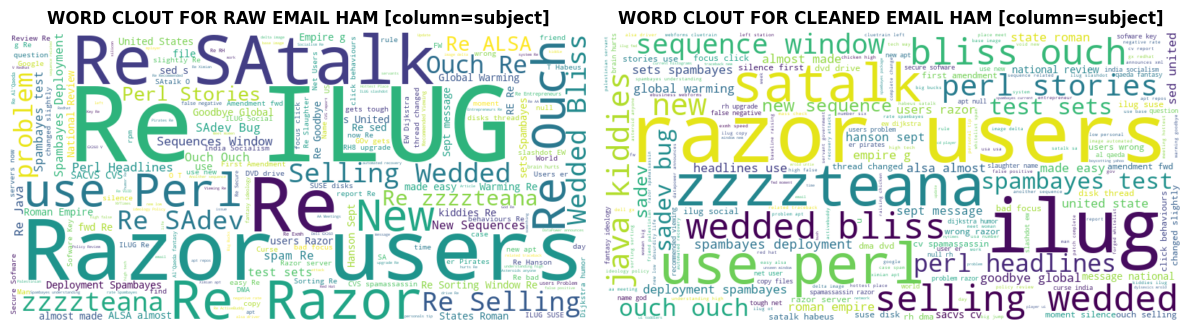

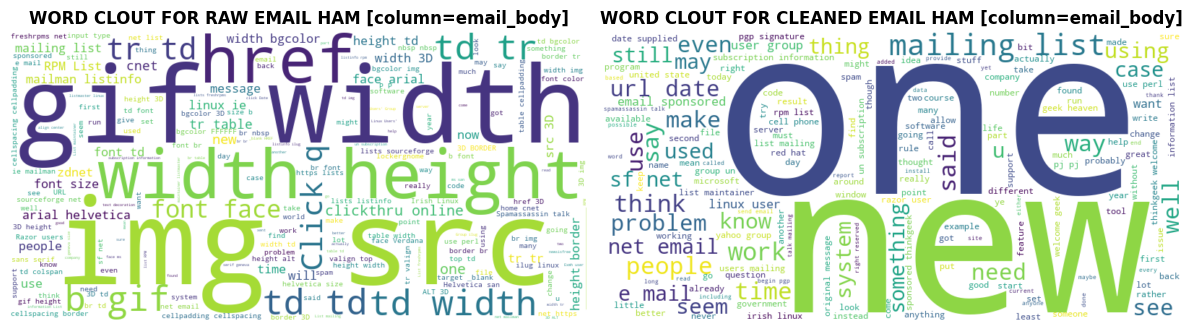

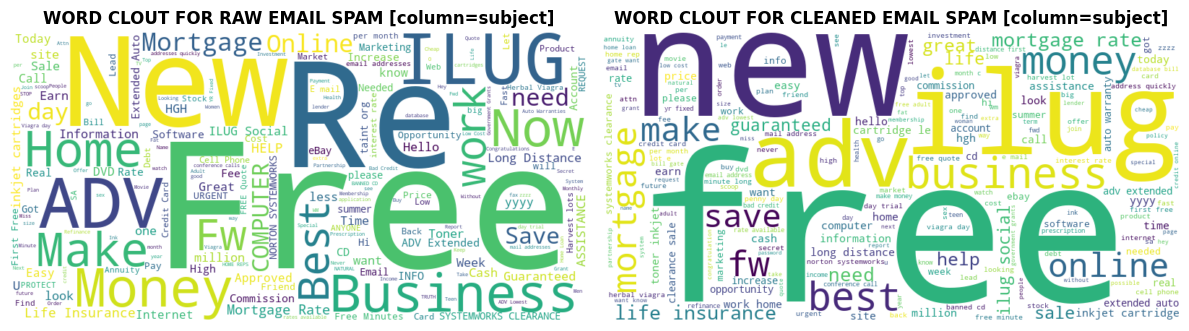

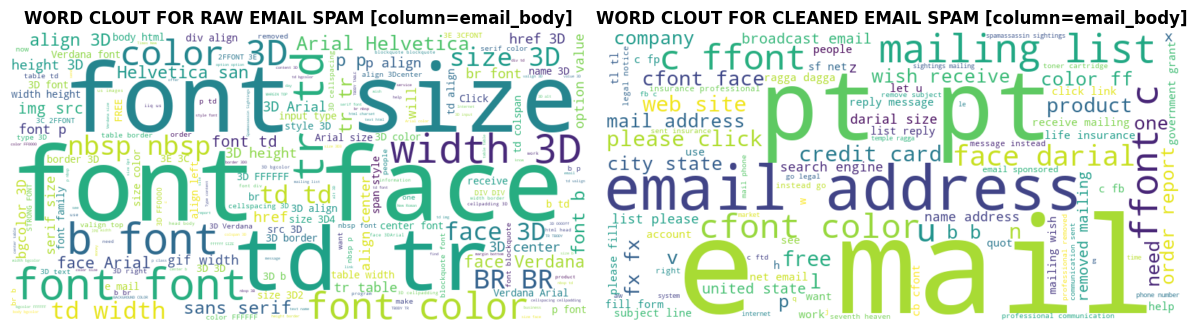

In [10]:
for idx, label in enumerate(labels):
    columns = ['subject', 'email_body']

    for column in columns:
        text_raw = " ".join(data_raw_df[data_raw_df.label == idx][column])
        text_cleaned = " ".join(data_cleaned_df[data_cleaned_df.label == idx][column].apply(lambda x : ' '.join(x)))

        wordcloud1 = WordCloud(width=800, height=400, background_color='white').generate(text_raw)
        wordcloud2 = WordCloud(width=800, height=400, background_color='white').generate(text_cleaned)

        plt.figure(figsize = (12, 8)) 

        # Plot the first word cloud
        plt.subplot(1, 2, 1)
        plt.imshow(wordcloud1, interpolation='bilinear')
        plt.axis('off')
        plt.title("WORD CLOUT FOR RAW EMAIL " + label.upper() + " [column=" + column + "]", weight='bold')

        # Plot the second word cloud
        plt.subplot(1, 2, 2)
        plt.imshow(wordcloud2, interpolation='bilinear')
        plt.axis('off')
        plt.title("WORD CLOUT FOR CLEANED EMAIL " + label.upper() + " [column=" + column + "]", weight='bold')

        # Show the plot
        plt.tight_layout()
        plt.show()

## Model Creation and Evaluation

### __I. Naive Bayes using Count Vectors with Unigram__
### a. Building Model (uncleaned data)

__Splitting Dataset:__ Separate the raw dataset to independent variable and dependent variable, then split the datasets into training and testing data

In [30]:
X_raw = data_raw_df.drop(['label'], axis=1)
y_raw = data_raw_df['label']

X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, test_size=0.3, random_state=42)

print("Train Data: ", X_train.shape, y_train.shape)
print("Test Data: ", X_test.shape, y_test.shape)

Train Data:  (6017, 4) (6017,)
Test Data:  (2580, 4) (2580,)


__Text Vectorization:__ Use CountVectorizer() class to convert the data into a numerical format

In [32]:
vectorizer = CountVectorizer()
transformer = make_column_transformer((vectorizer, 'subject'), (vectorizer, 'to'), (vectorizer, 'from'), (vectorizer, 'email_body'))

X_raw_train_vec = transformer.fit_transform(X_train)
X_raw_test_vec = transformer.transform(X_test)

X_raw_train_vec.shape, X_raw_test_vec.shape

((6017, 107187), (2580, 107187))

__Building Model:__ Utilize GridSearchCV to fine-tune the hyperparameter alpha prior to constructing the Naive Bayes model

In [33]:
classifier1 = MultinomialNB()
classifier1.fit(X_raw_train_vec, y_raw_train)

MultinomialNB()

__Model Evaluation:__ Predict the test data using model. Then get the accuracy and other evaluation metric report.

In [48]:
y_raw_train_pred = classifier1.predict(X_raw_train_vec)

accuracy = accuracy_score(y_raw_train, y_raw_train_pred)
precision = precision_score(y_raw_train, y_raw_train_pred)
report = classification_report(y_raw_train, y_raw_train_pred)

print("------------------------------------------------------")
print("               EVALUATION FOR TRAIN DATA")
print("------------------------------------------------------")
print(f"Accuracy: {round(accuracy, 4)}")
print(f"Precision: {round(precision, 4)}")
print("\nClassification Report:")
print(report)


y_raw_test_pred = classifier1.predict(X_raw_test_vec)

accuracy = accuracy_score(y_raw_test, y_raw_test_pred)
precision = precision_score(y_raw_test, y_raw_test_pred)
report = classification_report(y_raw_test, y_raw_test_pred)

print("------------------------------------------------------")
print("               EVALUATION FOR TEST DATA")
print("------------------------------------------------------")
print(f"Accuracy: {round(accuracy, 4)}")
print(f"Precision: {round(precision, 4)}")
print("\nClassification Report:")
print(report)

------------------------------------------------------
               EVALUATION FOR TRAIN DATA
------------------------------------------------------
Accuracy: 0.9847
Precision: 0.9891

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4671
           1       0.99      0.94      0.96      1346

    accuracy                           0.98      6017
   macro avg       0.99      0.97      0.98      6017
weighted avg       0.98      0.98      0.98      6017

------------------------------------------------------
               EVALUATION FOR TEST DATA
------------------------------------------------------
Accuracy: 0.9682
Precision: 0.9795

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2030
           1       0.98      0.87      0.92       550

    accuracy                           0.97      2580
   macro avg       0.97      0.93   

### b. Building Model (cleaned data)

__Splitting Dataset:__ Separate the cleaned dataset to independent variable and dependent variable, then split the datasets into training and testing data

In [38]:
X_cleaned = data_cleaned_df.drop(['label'], axis=1)
y_cleaned = data_cleaned_df['label']

X_cleaned = X_cleaned.applymap(lambda x : ' '.join(x))

X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size=0.3, random_state=42)

print("Train Data: ", X_train.shape, y_train.shape)
print("Test Data: ", X_test.shape, y_test.shape)

Train Data:  (6017, 4) (6017,)
Test Data:  (2580, 4) (2580,)


__Text Vectorization:__ Use CountVectorizer() class to convert the data into a numerical format

In [40]:
vectorizer = CountVectorizer()
transformer = make_column_transformer((vectorizer, 'subject'), (vectorizer, 'to'), (vectorizer, 'from'), (vectorizer, 'email_body'))

X_cleaned_train_vec = transformer.fit_transform(X_train)
X_cleaned_test_vec = transformer.transform(X_test)

X_cleaned_train_vec.shape, X_cleaned_test_vec.shape

((6017, 115483), (2580, 115483))

__Building Model:__ Utilize GridSearchCV to fine-tune the hyperparameter alpha prior to constructing the Naive Bayes model

In [41]:
classifier2 = MultinomialNB()
classifier2.fit(X_cleaned_train_vec, y_cleaned_train)

MultinomialNB()

__Model Evaluation:__ Predict the test data using model. Then get the accuracy and other evaluation metric report.

In [49]:
y_cleaned_train_pred = classifier2.predict(X_cleaned_train_vec)

accuracy = accuracy_score(y_cleaned_train, y_cleaned_train_pred)
precision = precision_score(y_cleaned_train, y_cleaned_train_pred)
report = classification_report(y_cleaned_train, y_cleaned_train_pred)

print("------------------------------------------------------")
print("               EVALUATION FOR TRAIN DATA")
print("------------------------------------------------------")
print(f"Accuracy: {round(accuracy, 4)}")
print(f"Precision: {round(precision, 4)}")
print("\nClassification Report:")
print(report)


y_cleaned_test_pred = classifier2.predict(X_cleaned_test_vec)

accuracy = accuracy_score(y_cleaned_test, y_cleaned_test_pred)
precision = precision_score(y_cleaned_test, y_cleaned_test_pred)
report = classification_report(y_cleaned_test, y_cleaned_test_pred)

print("------------------------------------------------------")
print("               EVALUATION FOR TEST DATA")
print("------------------------------------------------------")
print(f"Accuracy: {round(accuracy, 4)}")
print(f"Precision: {round(precision, 4)}")
print("\nClassification Report:")
print(report)

------------------------------------------------------
               EVALUATION FOR TRAIN DATA
------------------------------------------------------
Accuracy: 0.9864
Precision: 0.9976

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4671
           1       1.00      0.94      0.97      1346

    accuracy                           0.99      6017
   macro avg       0.99      0.97      0.98      6017
weighted avg       0.99      0.99      0.99      6017

------------------------------------------------------
               EVALUATION FOR TEST DATA
------------------------------------------------------
Accuracy: 0.9717
Precision: 0.9918

Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      2030
           1       0.99      0.87      0.93       550

    accuracy                           0.97      2580
   macro avg       0.98      0.94   

### __II. Naive Bayes using TF-IDF with Unigram+Bigram__
### a. Building Model  (uncleaned data)
__Splitting Dataset:__ Separate the raw dataset to independent variable and dependent variable, then split the datasets into training and testing data

In [86]:
X_raw = data_raw_df['email_body'] + " " + data_raw_df['to'] + " " + data_raw_df['from'] + " " + data_raw_df['subject']
y_raw = data_raw_df['label']

X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, test_size=0.3, random_state=42)

print("Train Data: ", X_train.shape, y_train.shape)
print("Test Data: ", X_test.shape, y_test.shape)

Train Data:  (6017,) (6017,)
Test Data:  (2580,) (2580,)


__Text Vectorization:__ Use TD/IDF Vectorizer to convert the data into a numerical format

In [63]:
tfidf_unibigrams_vectorizer = TfidfVectorizer(ngram_range=(1, 2))

X_train_tfidf = tfidf_unibigrams_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_unibigrams_vectorizer.transform(X_test)

X_train_tfidf.shape, X_test_tfidf.shape

((6017, 625103), (2580, 625103))

__Building Model:__ Utilize GridSearchCV to fine-tune the hyperparameter alpha prior to constructing the Naive Bayes model

In [65]:
param_grid = {
    'alpha': [0.1, 0.5, 1.0],
}

naive_bayes_classifier = MultinomialNB()
grid_search = GridSearchCV(estimator=naive_bayes_classifier, param_grid=param_grid, cv=3, scoring='accuracy')

grid_search.fit(X_train_tfidf, y_train)
best_model = grid_search.best_estimator_

print("\nModel: ", best_model)
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", round(grid_search.best_score_, 4))

y_raw_predict = grid_search.predict(X_train_tfidf)
precision = precision_score(y_train, y_raw_predict)
print("Precision:", round(precision, 4))


Model:  MultinomialNB(alpha=0.1)
Best Parameters: {'alpha': 0.1}
Best Accuracy: 0.9741
Precision: 0.9697


__Model Evaluation:__ Utilize the model to make predictions on the test data. Then get the metrics such as accuracy and other measures for evaluation

In [67]:
y_pred = best_model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Accuracy:", round(accuracy, 4))
print("Precision:", round(precision, 4))
print("Classification Report:\n", classification_rep)

Accuracy: 0.9756
Precision: 0.9656
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      2030
           1       0.97      0.92      0.94       550

    accuracy                           0.98      2580
   macro avg       0.97      0.95      0.96      2580
weighted avg       0.98      0.98      0.98      2580



### b. Building Model (cleaned data)

__Splitting Dataset:__ Separate the cleaned dataset to independent variable and dependent variable, then split the datasets into training and testing data

In [68]:
# Convert the list of values to string for each indepdent features
email_body =  data_cleaned_df['email_body'].apply(', '.join)
email_subject =  data_cleaned_df['subject'].apply(', '.join)
email_to =  data_cleaned_df['to'].apply(', '.join)
email_from =  data_cleaned_df['from'].apply(', '.join)

# Split independent variables and dependent variable
X_cleaned =  email_to + " " + email_from + " " + email_subject + " " + email_body
y_cleaned = data_cleaned_df['label']

X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size=0.3, random_state=42)

print("Train Data: ", X_train.shape, y_train.shape)
print("Test Data: ", X_test.shape, y_test.shape)

Train Data:  (6017,) (6017,)
Test Data:  (2580,) (2580,)


__Text Vectorization:__ Use TD/IDF Vectorizer to convert the data into a numerical format

In [69]:
tfidf_unibigrams_vectorizer = TfidfVectorizer(ngram_range=(1, 2))

X_train_tfidf = tfidf_unibigrams_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_unibigrams_vectorizer.transform(X_test)

X_train_tfidf.shape, X_test_tfidf.shape

((6017, 581475), (2580, 581475))

__Building Model:__ Utilize GridSearchCV to fine-tune the hyperparameter alpha prior to constructing the Naive Bayes model

In [71]:
param_grid = {
    'alpha': [0.1, 0.5, 1.0],
}

naive_bayes_classifier = MultinomialNB()
grid_search = GridSearchCV(estimator=naive_bayes_classifier, param_grid=param_grid, cv=3, scoring='accuracy')

grid_search.fit(X_train_tfidf, y_train)
best_model = grid_search.best_estimator_

print("\nModel: ", best_model)
print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy:", round(grid_search.best_score_, 4))

y_cleaned_predict = grid_search.predict(X_train_tfidf)
precision = precision_score(y_train, y_cleaned_predict)
print("Precision:", round(precision, 4))


Model:  MultinomialNB(alpha=0.1)
Best Parameters: {'alpha': 0.1}
Best Accuracy: 0.9844
Precision: 0.9985


__Model Evaluation:__ Predict the test data using model. Then get the accuracy and other evaluation metric report.

In [72]:
y_pred = best_model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print("Accuracy:", round(accuracy, 4))
print("Precision:", round(precision, 4))
print("Classification Report:\n", classification_rep)

Accuracy: 0.9798
Precision: 0.994
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      2030
           1       0.99      0.91      0.95       550

    accuracy                           0.98      2580
   macro avg       0.99      0.95      0.97      2580
weighted avg       0.98      0.98      0.98      2580



### __III. Naive Bayes using Word2Vec__
### a. Building Model (uncleaned data)
__Splitting Dataset:__ Separate the raw dataset to independent variable and dependent variable, then split the datasets into training and testing data

__Text Vectorization:__ Use TD/IDF Vectorizer to convert the data into a numerical format

__Building Model:__ Utilize GridSearchCV to fine-tune the hyperparameter alpha prior to constructing the Naive Bayes model

__Model Evaluation:__ Predict the test data using model. Then get the accuracy and other evaluation metric report.

### b. Building Model (cleaned data)
__Splitting Dataset:__ Separate the cleaned dataset to independent variable and dependent variable, then split the datasets into training and testing data

__Text Vectorization:__ Use TD/IDF Vectorizer to convert the data into a numerical format

__Building Model:__ Utilize GridSearchCV to fine-tune the hyperparameter alpha prior to constructing the Naive Bayes model

__Model Evaluation:__ Predict the test data using model. Then get the accuracy and other evaluation metric report.

### __IV. Naive Bayes using GloVe__
### Pre-requisite: Building Customized Vectorizer for GloVe Vectors
Access the file, then read and store the GloVe vectors in a dictionary. Obtain the data from this source: https://nlp.stanford.edu/projects/glove/. After which, create a customized function to get the mean of each vector of a word given the GloVe vectors.

In [21]:
embeddings_dict = {}

with open('glove.6B.100d.txt', 'r', encoding="utf-8") as file:
    for line in file:
        values = line.split()
        word = values[0]
        pattern = r'^[^\W_].*[^\W_]$'   # String does not start or end in special character
        if word not in stop_words and re.match(pattern, word):
            vector = np.asarray(values[1:], "float32")
            embeddings_dict[word] = vector


class MeanEmbeddingVectorizer(object):

    def __init__(self, word_vectors):
        self._word_vectors = word_vectors

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        try:
            # Determine the dimentionality of the vectors
            self.dim = len(next(iter(self._word_vectors.values())))

            # Initialize the list object with [size of data] x [dimension of word vector] 
            output = np.zeros((len(X), self.dim))

            for idx, sentence in enumerate(X):
                tokens = word_tokenize(sentence)
                vectors = []
                for word in tokens:
                    # If the given word exists in word vectors, return its vectors.
                    # Otherwise, return the default dimension with zero values 
                    vectors.append(self._word_vectors.get(word.lower(), [np.zeros(self.dim)]))    
                
                # Get the mean of the vectors of the words in a sentence
                if len(vectors) > 0:
                    output[idx] = np.mean(vectors, axis=0)[0]

        except Exception as err:
            print(f"ERROR: {err}")

        return output
    
    def fit_transform(self, X):
        return self.transform(X)

### a . Building Model (uncleaned data)

__Splitting Dataset:__ Separate the raw dataset to independent variable and dependent variable, then split the datasets into training and testing data

In [74]:
X_raw = data_raw_df.drop(['label'], axis=1)
y_raw = data_raw_df['label']

# Convert list values into string
X_raw = X_raw.apply(lambda row: ' '.join(row.astype(str)), axis=1)

# Split the data into training and testing datasets 
X_raw_train, X_raw_test, y_raw_train, y_raw_test = train_test_split(X_raw, y_raw, test_size=0.30, random_state=42)

print("Train Data: ", X_train.shape, y_train.shape)
print("Test Data: ", X_test.shape, y_test.shape)

Train Data:  (6017,) (6017,)
Test Data:  (2580,) (2580,)


__Text Vectorization:__ Use the customized vectorizer for Glove to convert the data into a numerical format

In [75]:
vectorizer = MeanEmbeddingVectorizer(embeddings_dict)

X_train_glove = vectorizer.fit_transform(X_raw_train)
X_test_glove = vectorizer.transform(X_raw_test)

X_train_glove.shape, X_test_glove.shape

((6017, 100), (2580, 100))

__Building Model:__ Utilize MinMaxScaler to scale each feature to 0 to 1 range of values. This will solve the issue on negative numbers as these values are not accepted by Multinomial Naive Bayes model

In [77]:
# Standardized the data, which will solve the issues with negative number on the data
scaler = MinMaxScaler()
X_raw_train_scaled = scaler.fit_transform(X_train_glove)
X_raw_test_scaled = scaler.transform(X_test_glove)

# Train a Multinomial Naive Bayes classifier
classifier1 = MultinomialNB()
classifier1.fit(X_raw_train_scaled, y_raw_train)

MultinomialNB()

__Model Evaluation:__ Predict the test data using model. Then get the accuracy and other evaluation metric report.

In [79]:
# Evaluate the train data
y_raw_train_pred = classifier1.predict(X_raw_train_scaled)

accuracy = accuracy_score(y_raw_train, y_raw_train_pred)
precision = precision_score(y_raw_train, y_raw_train_pred)
report = classification_report(y_raw_train, y_raw_train_pred)

print("------------------------------------------------------")
print("               EVALUATION FOR TRAIN DATA")
print("------------------------------------------------------")
print(f"Accuracy: {round(accuracy, 4)}")
print(f"Precision: {round(precision, 4)}")
print("\nClassification Report:")
print(report)


# Evaluate the test data
y_raw_test_pred = classifier1.predict(X_raw_test_scaled)

accuracy = accuracy_score(y_raw_test, y_raw_test_pred)
precision = precision_score(y_raw_test, y_raw_test_pred)
report = classification_report(y_raw_test, y_raw_test_pred)

print("------------------------------------------------------")
print("               EVALUATION FOR TEST DATA")
print("------------------------------------------------------")
print(f"Accuracy: {round(accuracy, 4)}")
print(f"Precision: {round(precision, 4)}")
print("\nClassification Report:")
print(report)

------------------------------------------------------
               EVALUATION FOR TRAIN DATA
------------------------------------------------------
Accuracy: 0.7763
Precision: 0.0

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.87      4671
           1       0.00      0.00      0.00      1346

    accuracy                           0.78      6017
   macro avg       0.39      0.50      0.44      6017
weighted avg       0.60      0.78      0.68      6017

------------------------------------------------------
               EVALUATION FOR TEST DATA
------------------------------------------------------
Accuracy: 0.7868
Precision: 0.0

Classification Report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88      2030
           1       0.00      0.00      0.00       550

    accuracy                           0.79      2580
   macro avg       0.39      0.50      0.4

### b. Building Model (cleaned data)

__Splitting Dataset:__ Separate the cleaned dataset to independent variable and dependent variable, then split the datasets into training and testing data

In [80]:
# Split independent variables and dependent variable
X_cleaned = data_cleaned_df.drop(['label'], axis=1)
y_cleaned = data_cleaned_df['label']

# Convert list values into string
X_cleaned = X_cleaned.apply(lambda row: ' '.join(row.astype(str)), axis=1)

# Split the data into training and testing datasets 
X_cleaned_train, X_cleaned_test, y_cleaned_train, y_cleaned_test = train_test_split(X_cleaned, y_cleaned, test_size=0.30, random_state=42)

print("Train Data: ", X_train.shape, y_train.shape)
print("Test Data: ", X_test.shape, y_test.shape)

Train Data:  (6017,) (6017,)
Test Data:  (2580,) (2580,)


__Text Vectorization:__ Use the customized vectorizer for Glove to convert the data into a numerical format

In [81]:
vectorizer = MeanEmbeddingVectorizer(embeddings_dict)

X_train_glove = vectorizer.fit_transform(X_cleaned_train)
X_test_glove = vectorizer.transform(X_cleaned_test)

X_train_glove.shape, X_test_glove.shape

((6017, 100), (2580, 100))

__Building Model:__ Utilize MinMaxScaler to scale each feature to 0 to 1 range of values. This will solve the issue on negative numbers as these values are not accepted by Multinomial Naive Bayes model

In [82]:
# Standardized the data, which will solve the issues with negative number on the data
scaler = MinMaxScaler()
X_cleaned_train_scaled = scaler.fit_transform(X_train_glove)
X_cleaned_test_scaled = scaler.transform(X_test_glove)

# Train a Multinomial Naive Bayes classifier
classifier2 = MultinomialNB()
classifier2.fit(X_cleaned_train_scaled, y_cleaned_train)

MultinomialNB()

__Model Evaluation:__ Predict the test data using model. Then get the accuracy and other evaluation metric report.

In [83]:
# Evaluate the train data
y_cleaned_train_pred = classifier2.predict(X_cleaned_train_scaled)

accuracy = accuracy_score(y_cleaned_train, y_cleaned_train_pred)
precision = precision_score(y_cleaned_train, y_cleaned_train_pred)
report = classification_report(y_cleaned_train, y_cleaned_train_pred)

print("------------------------------------------------------")
print("               EVALUATION FOR TRAIN DATA")
print("------------------------------------------------------")
print(f"Accuracy: {round(accuracy, 4)}")
print(f"Precision: {round(precision, 4)}")
print("\nClassification Report:")
print(report)


# Evaluate the test data
y_cleaned_test_pred = classifier2.predict(X_cleaned_test_scaled)

accuracy = accuracy_score(y_cleaned_test, y_cleaned_test_pred)
precision = precision_score(y_cleaned_test, y_cleaned_test_pred)
report = classification_report(y_cleaned_test, y_cleaned_test_pred)

print("------------------------------------------------------")
print("               EVALUATION FOR TEST DATA")
print("------------------------------------------------------")
print(f"Accuracy: {round(accuracy, 4)}")
print(f"Precision: {round(precision, 4)}")
print("\nClassification Report:")
print(report)

------------------------------------------------------
               EVALUATION FOR TRAIN DATA
------------------------------------------------------
Accuracy: 0.7773
Precision: 0.6071

Classification Report:
              precision    recall  f1-score   support

           0       0.78      1.00      0.87      4671
           1       0.61      0.01      0.02      1346

    accuracy                           0.78      6017
   macro avg       0.69      0.51      0.45      6017
weighted avg       0.74      0.78      0.68      6017

------------------------------------------------------
               EVALUATION FOR TEST DATA
------------------------------------------------------
Accuracy: 0.7884
Precision: 0.5909

Classification Report:
              precision    recall  f1-score   support

           0       0.79      1.00      0.88      2030
           1       0.59      0.02      0.05       550

    accuracy                           0.79      2580
   macro avg       0.69      0.51   

## Conclusions

The table below displays the accuracy scores and precision scores for different methods used with the Multinomial Naive Bayes model for both raw and cleaned dataset. These scores only consider the test data, but there's no significant difference with the train data scores. After evaluating the results, the model's accuracy has shown improvement with cleaned data, although it's not very significant. However, there's a big improvement in precision when GloVe vectors. It went from zero precision to nearly 60%.


Accuracy scores for each vectorizer on both raw and cleaned data 
</br>

| Vectorizer        | Raw Data   | Cleaned Data |
| ----------------- | ---------- | ------------ |
| CountVectorizer   | 0.9682     | 0.9717       |
| TD-IDF            | 0.9756     | 0.9798       |
| Word2Vec          |            |              |
| GloVe             | 0.7868     | 0.7884       |

</br>
Precision scores for each vectorizer on both raw and cleaned data 
</br></br>

| Vectorizer        | Raw Data  | Cleaned Data |
| ----------------- | --------- | ------------ |
| CountVectorizer   | 0.9795    | 0.9918       |
| TD-IDF            | 0.9656    | 0.994        |
| Word2Vec          |           |              |
| GloVe             | 0         | 0.5909       |


## Recommendations

- Since some incorrectly spelled words were not handled during data cleaning, it could affect how the model learns. To make the model better, we should include the uncleaned data, which may have misspelled words, abbreviations, or slangs.
- For GloVe vectorization, we just average the vectors of all the words in a sentence. This is a simpliest way to calculate the vectors. However, when we checked the results, the scores dropped significantly, especially the precision, which is important metrics for spotting email spam. We should try a different approach for using GloVe vectors to calculate word vectors. In addition, a bigger vector dimensions like <a href="https://nlp.stanford.edu/data/glove.42B.300d.zip">glove.42B.300d.zip</a> and <a href="https://nlp.stanford.edu/data/glove.840B.300d.zip">glove.840B.300d.zip</a> can be used for pre-trained vectors.

## References
- https://coderzcolumn.com/tutorials/python/email-how-to-represent-an-email-message-in-python
- https://medium.com/analytics-vidhya/basics-of-using-pre-trained-glove-vectors-in-python-d38905f356db
- https://edumunozsala.github.io/BlogEms/jupyter/nlp/classification/embeddings/python/2020/08/15/Intro_NLP_WordEmbeddings_Classification.html#Loading-a-pre-trained-word-embedding:-GloVe